In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor  
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier


#Row and Column Setting

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [6]:
df = pd.read_csv('D:/pandas/Titanic_train.csv')


In [8]:
def check_df(dataframe, head=5):
    print(' ----------Shape----------')
    print(dataframe.shape)
    print(' ----------Types---------- ')
    print(dataframe.dtypes)
    print(' ----------Head---------- ')
    print(dataframe.head(head))
    print(' ----------Tail---------- ')
    print(dataframe.tail(head))
    print(' ----------NA---------- ')
    print(dataframe.isnull().sum())
    print(' ----------Quantiles---------- ')
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

 ----------Shape----------
(891, 12)
 ----------Types---------- 
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
 ----------Head---------- 
   PassengerId  Survived  Pclass                                               Name     Sex    Age  SibSp  Parch            Ticket   Fare Cabin Embarked
0            1         0       3                            Braund, Mr. Owen Harris    male 22.000      1      0         A/5 21171  7.250   NaN        S
1            2         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female 38.000      1      0          PC 17599 71.283   C85        C
2            3         1       3                             Heikkinen, Miss. Laina  female 26.000      0      0  STON/O2. 3101282  7.925   NaN        S
3     

In [9]:
df.columns = [col.upper() for col in df.columns]
df.head()

,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [19]:
# Cabin Bool

df["New_CABIN_BOOL"] = df["CABIN"].notnull().astype("int")


In [20]:
# Name Count

df["NEW_NAME_COUNT"] = df["NAME"].str.len()


In [22]:
df["NEW_NAME_WORD_COUNT"] = df["NAME"].apply(lambda x: len(str(x).split(" ")))


In [23]:

df["NEW_NAME_DR"] = df["NAME"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))

In [25]:
# Name Title

df["NEW_TITLE"] = df.NAME.str.extract(" ([A-Za-z]+)/.", expand=False)

In [26]:
# Family Size

df["NEW_FAMILY_SIZE"] = df["SIBSP"] + df["PARCH"] + 1

In [28]:
# Age_Pclass

df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]

In [29]:
# IS Alone

df.loc[((df["SIBSP"] + df["PARCH"]) > 0), "NEW_IS_ALONE"] = "NO"
df.loc[((df["SIBSP"] + df["PARCH"]) == 0), "NEW_IS_ALONE"] = "YES"

In [30]:
# Age Level

df.loc[(df["AGE"] < 18), "NEW_AGE_CAT"] = "young"
df.loc[(df["AGE"] >= 18) & (df["AGE"] < 56), "NEW_AGE_CAT"] = "mature"
df.loc[(df["AGE"] >= 56), "NEW_AGE_CAT"] = "senior"

In [31]:
# sex x age

df.loc[(df["SEX"] == "male") & (df["AGE"] <= 21), "NEW_SEX_CAT"] = "youngmale"
df.loc[(df["SEX"] == "male") & ((df["AGE"] > 21) & (df["AGE"]) <= 50), "NEW_SEX_CAT"] = "maturemale"
df.loc[(df["SEX"] == "male") & (df["AGE"] > 50), "NEW_SEX_CAT"] = "seniormale"
df.loc[(df["SEX"] == "female") & (df["AGE"] <= 21), "NEW_SEX_CAT"] = "youngfemale"
df.loc[(df["SEX"] == "female") & ((df["AGE"] > 21) & (df["AGE"]) <= 50), "NEW_SEX_CAT"] = "maturefemale"
df.loc[(df["SEX"] == "female") & (df["AGE"] > 50), "NEW_SEX_CAT"] = "seniorfemale"

In [32]:
df.head()

,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED,New_CABIN_BOOL,NEW_NAME_WORD_COUNT,NEW_TITLE,NEW_NAME_COUNT,NEW_NAME_DR,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S,0,4,NaN,23,0,2,66.000,NO,mature,maturemale
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C,1,7,NaN,51,0,2,38.000,NO,mature,maturefemale
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,0,3,NaN,22,0,1,78.000,YES,mature,maturefemale
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S,1,7,NaN,44,0,2,35.000,NO,mature,maturefemale
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S,0,4,NaN,24,0,1,105.000,YES,mature,maturemale


In [34]:
# Analysis of Variables

def grab_col_names(dataframe, cat_th=10, car_th=20):
     # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"] 

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car] 

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"] 

    num_cols = [col for col in num_cols if col not in num_but_cat] 
    
    print(f"Observations: {dataframe.shape[0]}") 
    print(f"Variables: {dataframe.shape[1]}") 
    print(f'cat_cols: {len(cat_cols)}') 
    print(f'num_cols: {len(num_cols)}') 
    print(f'cat_but_car: {len(cat_but_car)}') 
    print(f'num_but_cat: {len(num_but_cat)}') 


    return cat_cols, num_cols, cat_but_car, num_but_cat


In [35]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

Observations: 891
Variables: 22
cat_cols: 14
num_cols: 5
cat_but_car: 3
num_but_cat: 8


In [36]:
cat_cols

['SEX',
 'EMBARKED',
 'NEW_TITLE',
 'NEW_IS_ALONE',
 'NEW_AGE_CAT',
 'NEW_SEX_CAT',
 'SURVIVED',
 'PCLASS',
 'SIBSP',
 'PARCH',
 'New_CABIN_BOOL',
 'NEW_NAME_WORD_COUNT',
 'NEW_NAME_DR',
 'NEW_FAMILY_SIZE']

In [37]:
num_cols

['PASSENGERID', 'AGE', 'FARE', 'NEW_NAME_COUNT', 'NEW_AGE_PCLASS']

In [38]:
num_cols = [col for col in num_cols if "PASSENGERID" not in col]

In [39]:
cat_but_car

['NAME', 'TICKET', 'CABIN']

In [40]:
num_but_cat

['SURVIVED',
 'PCLASS',
 'SIBSP',
 'PARCH',
 'New_CABIN_BOOL',
 'NEW_NAME_WORD_COUNT',
 'NEW_NAME_DR',
 'NEW_FAMILY_SIZE']

In [41]:
# Categorical Summary Function

def cat_summary(dataframe, col_name, plot=False):
    if dataframe[col_name].dtypes == "bool":
        dataframe[col_name] = dataframe[col_name].astype(int)

        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                            "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
        print("-----------------------------------")

        if plot:
            sns.countplot(x=dataframe[col_name], data=dataframe)
            plt.show(block=True)
    else:
        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                            "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
        print("------------------------------------")

        if plot:
            sns.countplot(x=dataframe[col_name], data=dataframe)
            plt.show(block=True)

        SEX  Ratio
SEX               
male    577 64.759
female  314 35.241
------------------------------------


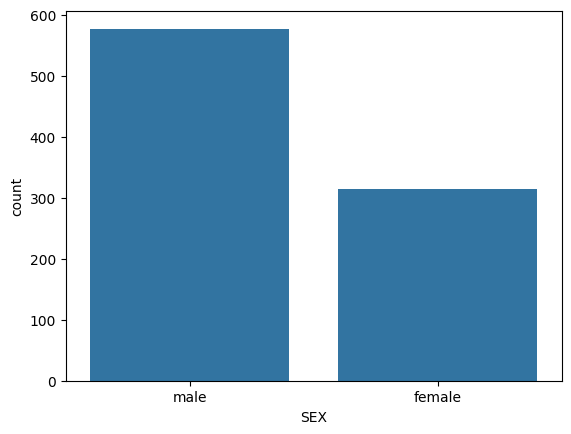

          EMBARKED  Ratio
EMBARKED                 
S              644 72.278
C              168 18.855
Q               77  8.642
------------------------------------


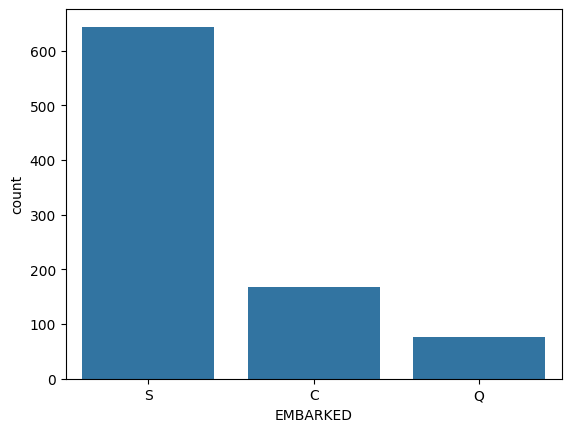

           NEW_TITLE  Ratio
NEW_TITLE                  
Carl               1  0.112
------------------------------------


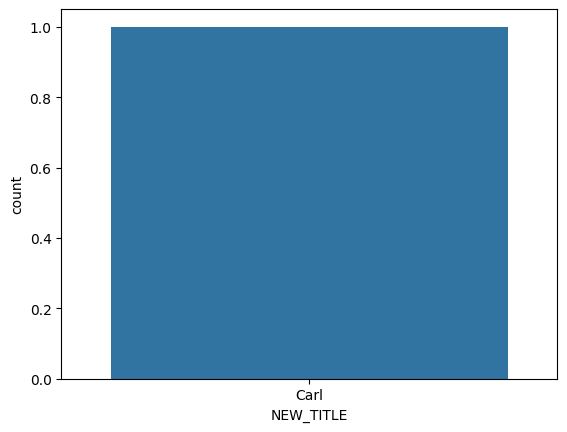

              NEW_IS_ALONE  Ratio
NEW_IS_ALONE                     
YES                    537 60.269
NO                     354 39.731
------------------------------------


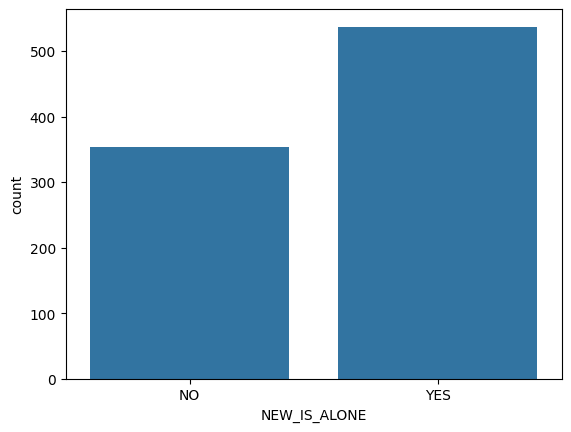

             NEW_AGE_CAT  Ratio
NEW_AGE_CAT                    
mature               562 63.075
young                113 12.682
senior                39  4.377
------------------------------------


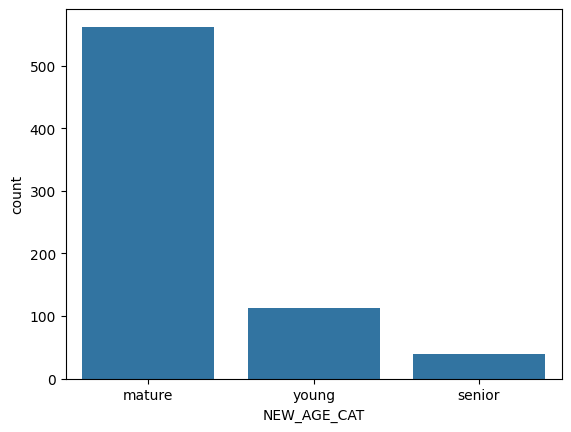

              NEW_SEX_CAT  Ratio
NEW_SEX_CAT                     
maturemale            530 59.484
maturefemale          297 33.333
seniormale             47  5.275
seniorfemale           17  1.908
------------------------------------


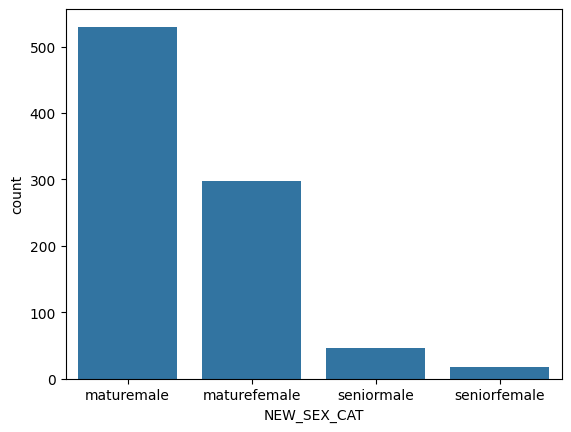

          SURVIVED  Ratio
SURVIVED                 
0              549 61.616
1              342 38.384
------------------------------------


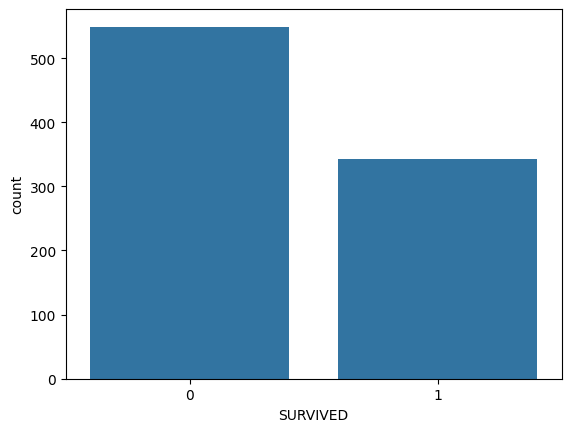

        PCLASS  Ratio
PCLASS               
3          491 55.107
1          216 24.242
2          184 20.651
------------------------------------


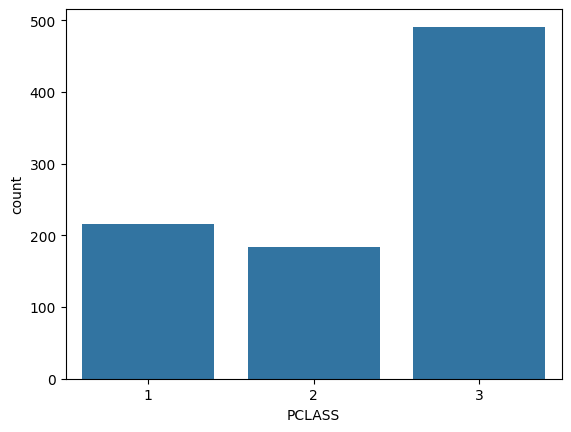

       SIBSP  Ratio
SIBSP              
0        608 68.238
1        209 23.457
2         28  3.143
4         18  2.020
3         16  1.796
8          7  0.786
5          5  0.561
------------------------------------


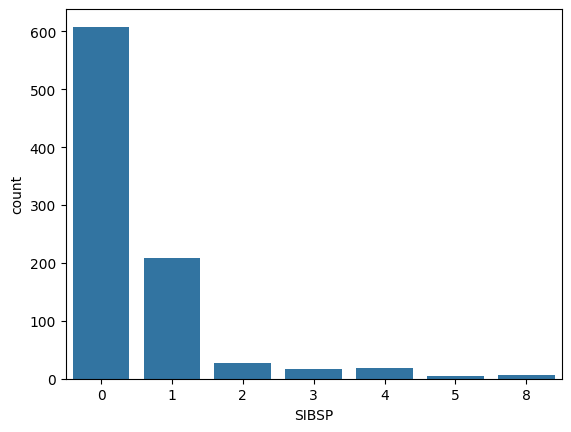

       PARCH  Ratio
PARCH              
0        678 76.094
1        118 13.244
2         80  8.979
5          5  0.561
3          5  0.561
4          4  0.449
6          1  0.112
------------------------------------


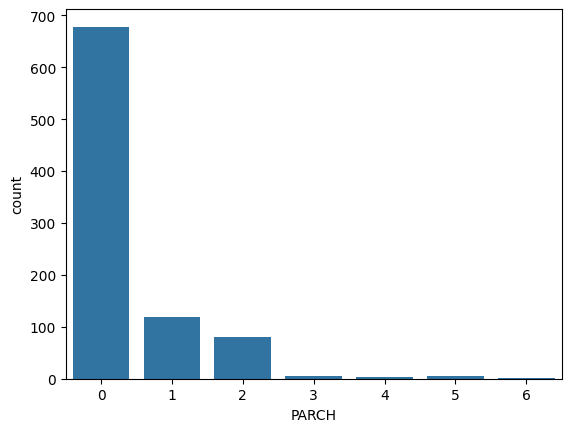

                New_CABIN_BOOL  Ratio
New_CABIN_BOOL                       
0                          687 77.104
1                          204 22.896
------------------------------------


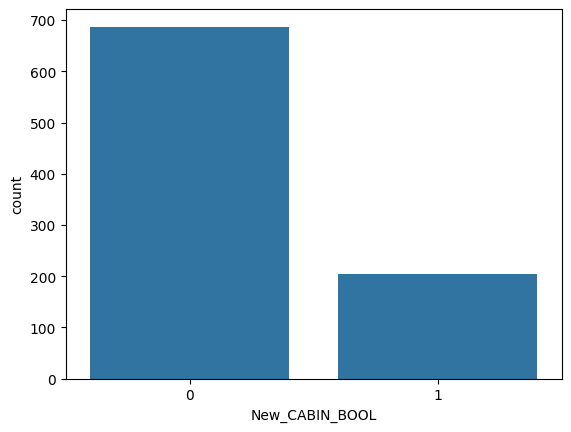

                     NEW_NAME_WORD_COUNT  Ratio
NEW_NAME_WORD_COUNT                            
4                                    388 43.547
3                                    305 34.231
5                                     96 10.774
6                                     53  5.948
7                                     38  4.265
8                                      9  1.010
14                                     1  0.112
9                                      1  0.112
------------------------------------


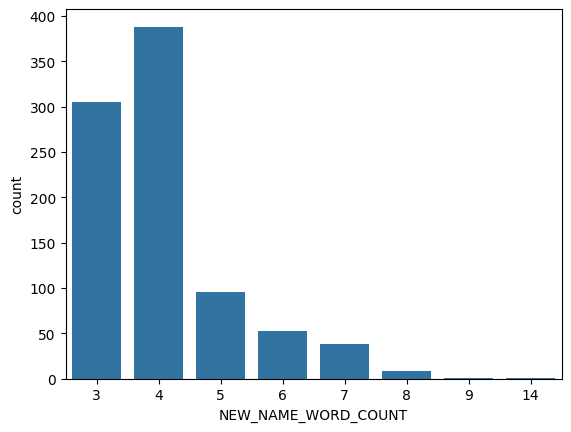

             NEW_NAME_DR  Ratio
NEW_NAME_DR                    
0                    881 98.878
1                     10  1.122
------------------------------------


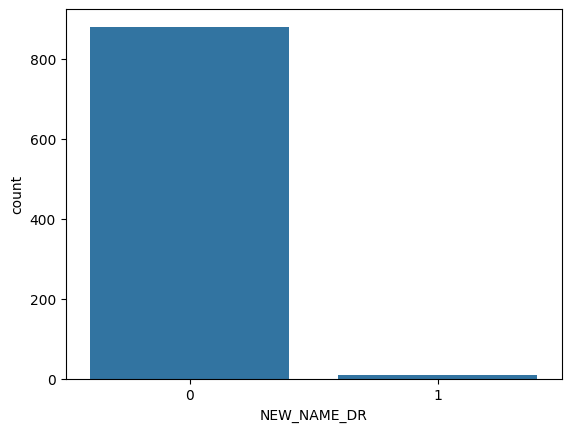

                 NEW_FAMILY_SIZE  Ratio
NEW_FAMILY_SIZE                        
1                            537 60.269
2                            161 18.070
3                            102 11.448
4                             29  3.255
6                             22  2.469
5                             15  1.684
7                             12  1.347
11                             7  0.786
8                              6  0.673
------------------------------------


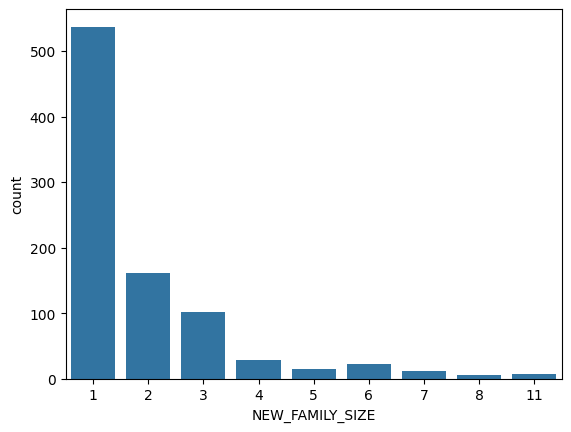

In [42]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

count   714.000
mean     29.699
std      14.526
min       0.420
5%        4.000
10%      14.000
20%      19.000
30%      22.000
40%      25.000
50%      28.000
60%      31.800
70%      36.000
80%      41.000
90%      50.000
95%      56.000
99%      65.870
max      80.000
Name: AGE, dtype: float64


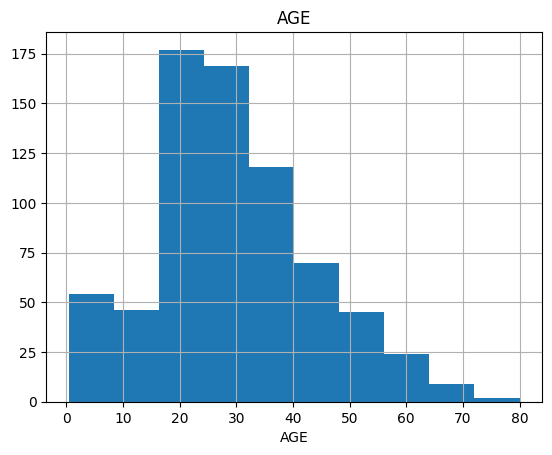

count   891.000
mean     32.204
std      49.693
min       0.000
5%        7.225
10%       7.550
20%       7.854
30%       8.050
40%      10.500
50%      14.454
60%      21.679
70%      27.000
80%      39.688
90%      77.958
95%     112.079
99%     249.006
max     512.329
Name: FARE, dtype: float64


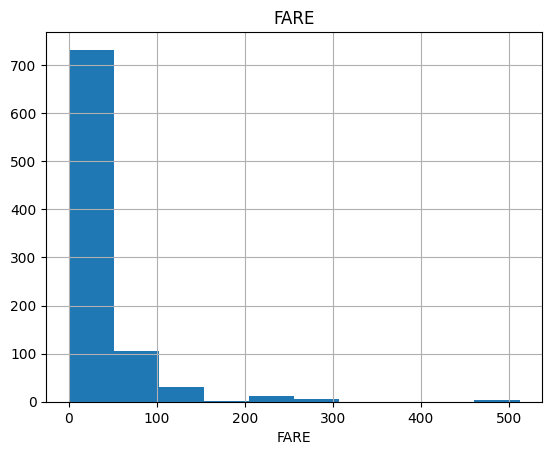

count   891.000
mean     26.965
std       9.282
min      12.000
5%       16.000
10%      17.000
20%      19.000
30%      21.000
40%      23.000
50%      25.000
60%      27.000
70%      29.000
80%      32.000
90%      41.000
95%      47.000
99%      55.100
max      82.000
Name: NEW_NAME_COUNT, dtype: float64


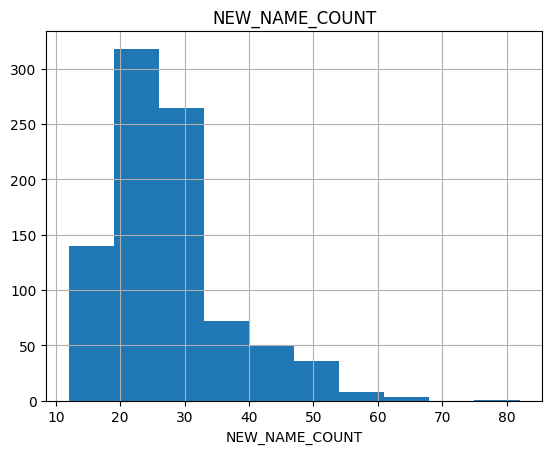

count   714.000
mean     61.938
std      34.380
min       0.920
5%       12.000
10%      21.000
20%      34.600
30%      44.900
40%      51.000
50%      58.000
60%      65.000
70%      75.000
80%      87.000
90%     108.000
95%     124.700
99%     153.000
max     222.000
Name: NEW_AGE_PCLASS, dtype: float64


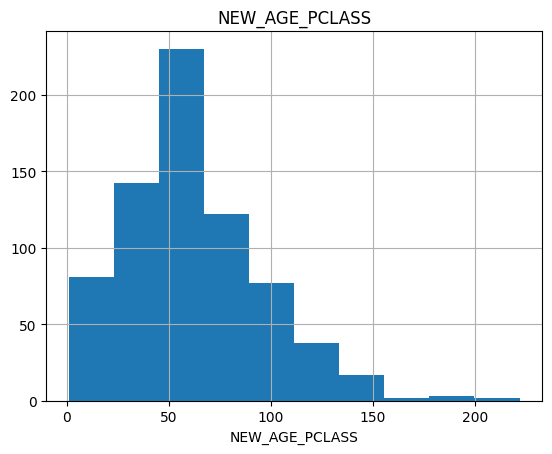

In [43]:
# Numerical Summary Function

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)
for col in num_cols:
    num_summary(df, col, plot=True)

In [44]:
# Outlier Threshold Calculation Function

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [45]:
# Outlier Check Function

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [46]:
# Replace Outliers with Thresholds

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [47]:
# Visualizing Outliers in a Boxplot

def boxplot_outliers(dataframe, col_name):
    plt.figure(figsize=(5, 5))
    sns.boxplot(x=dataframe[col_name])
    plt.show(block=True)

In [48]:
for col in num_cols:
    print(col, check_outlier(df, col))

AGE False
FARE True
NEW_NAME_COUNT False
NEW_AGE_PCLASS False


In [51]:
for col in num_cols:
    print(col, replace_with_thresholds(df, col))

AGE None
FARE None
NEW_NAME_COUNT None
NEW_AGE_PCLASS None


In [52]:
for col in num_cols:
    print(col, check_outlier(df, col))

AGE False
FARE False
NEW_NAME_COUNT False
NEW_AGE_PCLASS False


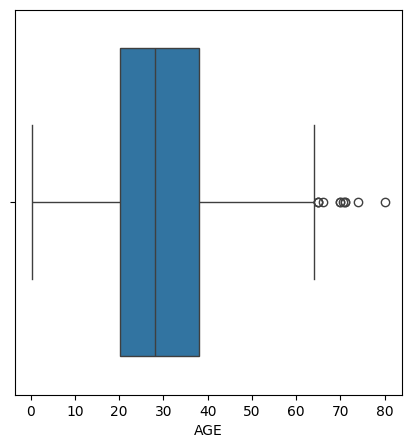

AGE None


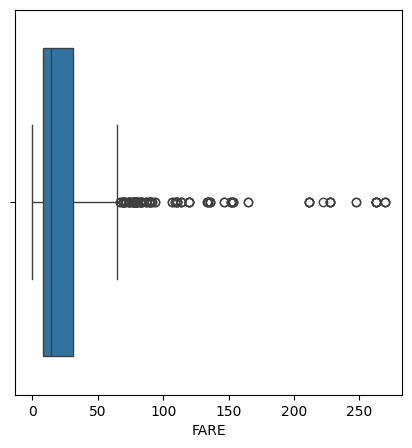

FARE None


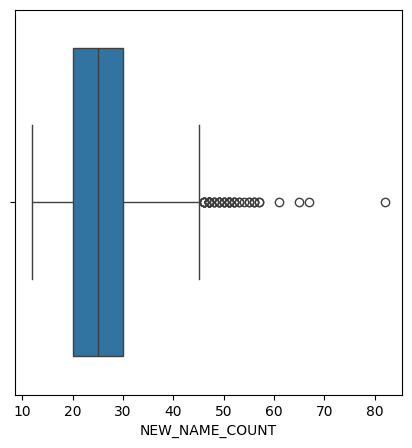

NEW_NAME_COUNT None


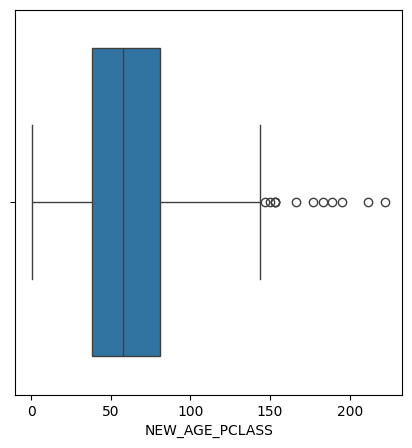

NEW_AGE_PCLASS None


In [53]:
for col in num_cols:
    print(col, boxplot_outliers(df, col))